<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define your data directories
train_dir = '/content/drive/MyDrive/train_imadjust_sobel_diff_alpha0.5'
val_dir = '/content/drive/MyDrive/validation_imadjust_sobel_diff_alpha0.5'
test_dir = '/content/drive/MyDrive/test_imadjust_sobel_diff_alpha0.5'

In [ ]:
# Combine train and validation directories for cross-validation
def gather_paths_and_labels(directory):
    data = []
    for label, class_name in enumerate(['Normal', 'Scol']):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            data.append((os.path.join(class_dir, file), label))
    return np.array(data)

train_data = gather_paths_and_labels(train_dir)
val_data = gather_paths_and_labels(val_dir)
test_data = gather_paths_and_labels(test_dir)

# Merge train and validation data for cross-validation
train_val_data = np.concatenate((train_data, val_data))


In [ ]:
# Model creation function
def create_densenet201_model():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
# Cross-validation function
def run_cross_validation(data, n_splits=5, epochs=50, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data[:, 0], data[:, 1])):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        train_files, val_files = data[train_idx], data[val_idx]

        train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': train_files[:, 0], 'class': train_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=True
        )

        val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': val_files[:, 0], 'class': val_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=False
        )

        model = create_densenet201_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping], verbose=1)

        val_labels = val_files[:, 1].astype(int)
        val_preds = (model.predict(val_gen) > 0.5).astype(int).ravel()

        accuracy_list.append((val_preds == val_labels).mean())
        precision_list.append(precision_score(val_labels, val_preds))
        recall_list.append(recall_score(val_labels, val_preds))
        f1_list.append(f1_score(val_labels, val_preds))

    print("\n5-Fold Cross-Validation Results:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

    return model


In [ ]:
# Run cross-validation
final_model = run_cross_validation(train_val_data)


=== Fold 1/5 ===
Found 171 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.6955 - loss: 0.6359 - val_accuracy: 0.7209 - val_loss: 0.5458
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6680 - loss: 0.6420 - val_accuracy: 0.7209 - val_loss: 0.4694
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7561 - loss: 0.4745 - val_accuracy: 0.7209 - val_loss: 0.4150
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8271 - loss: 0.3981 - val_accuracy: 0.8140 - val_loss: 0.3682
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8364 - loss: 0.3533 - val_accuracy: 0.9302 - val_loss: 0.3301
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8883 - loss: 0.3094 - val_accuracy: 0.9302 - val_loss: 0.3025
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9049 - loss: 0.2843 - val_accuracy: 0.9302 - val_loss: 0.2861
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9314 - loss: 0.2425 - val_accuracy: 0.9302 - val_loss: 0.2716
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.5149 - loss: 0.7290 - val_accuracy: 0.7209 - val_loss: 0.5471
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6955 - loss: 0.5624 - val_accuracy: 0.7209 - val_loss: 0.5317
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7941 - loss: 0.4446 - val_accuracy: 0.7209 - val_loss: 0.4743
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7976 - loss: 0.3911 - val_accuracy: 0.7907 - val_loss: 0.4081
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.8535 - loss: 0.3868 - val_accuracy: 0.8372 - val_loss: 0.3753
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8434 - loss: 0.3511 - val_accuracy: 0.8605 - val_loss: 0.3480
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9081 - loss: 0.2994 - val_accuracy: 0.8837 - val_loss: 0.3260
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8506 - loss: 0.3362 - val_accuracy: 0.9070 - val_loss: 0.3024
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.4947 - loss: 0.8080 - val_accuracy: 0.6977 - val_loss: 0.5510
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7218 - loss: 0.6006 - val_accuracy: 0.7209 - val_loss: 0.5340
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7251 - loss: 0.5314 - val_accuracy: 0.7209 - val_loss: 0.4749
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.6962 - loss: 0.5033 - val_accuracy: 0.7442 - val_loss: 0.4047
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8174 - loss: 0.3894 - val_accuracy: 0.8372 - val_loss: 0.3662
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8324 - loss: 0.4005 - val_accuracy: 0.9302 - val_loss: 0.3353
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8792 - loss: 0.3411 - val_accuracy: 0.9302 - val_loss: 0.3063
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8181 - loss: 0.3573 - val_accuracy: 0.9302 - val_loss: 0.2823
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.5997 - loss: 0.6544 - val_accuracy: 0.7209 - val_loss: 0.5051
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.7328 - loss: 0.4956 - val_accuracy: 0.7209 - val_loss: 0.4923
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7412 - loss: 0.5224 - val_accuracy: 0.7442 - val_loss: 0.4105
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.8012 - loss: 0.3964 - val_accuracy: 0.9302 - val_loss: 0.3583
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8470 - loss: 0.3939 - val_accuracy: 0.9535 - val_loss: 0.3301
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.8655 - loss: 0.3511 - val_accuracy: 0.9535 - val_loss: 0.3014
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9329 - loss: 0.2842 - val_accuracy: 0.9535 - val_loss: 0.2850
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9406 - loss: 0.2526 - val_accuracy: 0.9767 - val_loss: 0.2674
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.6037 - loss: 0.6791 - val_accuracy: 0.7381 - val_loss: 0.4681
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6900 - loss: 0.5530 - val_accuracy: 0.7381 - val_loss: 0.4245
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7327 - loss: 0.5148 - val_accuracy: 0.7619 - val_loss: 0.3749
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.8159 - loss: 0.4152 - val_accuracy: 0.8810 - val_loss: 0.3434
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8779 - loss: 0.3690 - val_accuracy: 0.8810 - val_loss: 0.3201
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.8696 - loss: 0.3337 - val_accuracy: 0.8571 - val_loss: 0.2977
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8879 - loss: 0.2953 - val_accuracy: 0.9048 - val_loss: 0.2790
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.8777 - loss: 0.3117 - val_accuracy: 0.8571 - val_loss: 0.2653
Epoch

In [ ]:
# Test set evaluation
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    pd.DataFrame({'filename': test_data[:, 0], 'class': test_data[:, 1]}),
    x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

test_labels = test_data[:, 1].astype(int)
test_preds = (final_model.predict(test_gen) > 0.5).astype(int).ravel()

Found 41 validated image filenames belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step



Test Set Confusion Matrix:
[[11  1]
 [ 0 29]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96        12
        Scol       0.97      1.00      0.98        29

    accuracy                           0.98        41
   macro avg       0.98      0.96      0.97        41
weighted avg       0.98      0.98      0.98        41



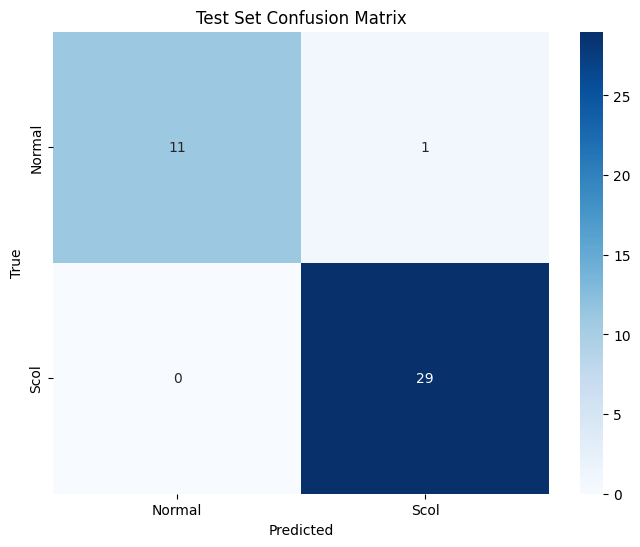

In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(test_labels, test_preds)
print("\nTest Set Confusion Matrix:")
print(cm)
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Scol']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scol'], yticklabels=['Normal', 'Scol'])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()